# Data Centric Approach
In this notebook we will follow a data centric approach and try to improve predictions for relKa.

In [1]:
#Mount  Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/My\ Drive/Colab\ Notebooks/ML\ Project2

In [2]:
#Usefull Libraries

# pandas / numpy
import pandas as pd
import numpy as np
#matplotlib
from matplotlib import pyplot as plt

#import xgboost regressor model
from xgboost import XGBRegressor

#pearson corelation coefficient
from scipy.stats import pearsonr
#spearman corelation coefficient
from scipy.stats import spearmanr

#import cross validation function from sklearn
from sklearn.model_selection import cross_val_score
#import one hot encoder function from sklearn
from sklearn.preprocessing import OneHotEncoder
#import the train test split function from sklearn to split the dataset randomly for training and testing
from sklearn.model_selection import train_test_split
#import mse loss
from sklearn.metrics import mean_squared_error

In [3]:
#import data from zip
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False)
#print the first samples of the dataframe to get a look at the data
pddata.head(4)

,Unnamed: 0,Kmer,y_1,y_2,y_3,y_4,y_5,y_6,zC_1,zC_2,...,zW_76,zW_77,zW_78,y_79,y_80,y_81,y_82,y_83,y_84,relKa
0,0,AATGATTAATTACC,0.593697,-1.092779,0.309117,0.133525,0.023403,-0.157348,1.177586,-2.166888,...,-0.674709,10.019444,-1.012806,-0.790300,-0.112492,0.118705,0.237596,-0.009713,0.267886,1.00000
1,1,GGTAATTAATCATT,0.790300,-0.112492,0.118705,-0.237596,-0.009713,0.267886,2.591673,-3.422281,...,-0.986852,9.851130,-1.990198,-0.593697,-1.092779,0.309117,-0.133525,0.023403,-0.157348,1.00000
2,2,AATGATTAATTACT,0.593690,-1.092780,0.309116,0.133525,0.023403,-0.157348,1.177587,-2.166890,...,-0.839165,10.065669,-1.499679,-0.826872,-1.141872,0.500342,-0.143809,0.043456,0.095141,0.96883
3,3,AGTAATTAATCATT,0.826872,-1.141872,0.500342,0.143809,0.043456,0.095141,2.137980,-2.777053,...,-0.986851,9.851129,-1.990198,-0.593690,-1.092780,0.309116,-0.133525,0.023403,-0.157348,0.96883


In [4]:
#convert dataframe to np array
data = pddata.to_numpy()
#labels
y = data[:,320:]
# features
# we remove the index of the data samples, since it is not a feature
x = data[:,1:320]
# temporarily remove the 2nd feature because one hot encoding causes ram overflow
x = x[:,1:]

In [5]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(y) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

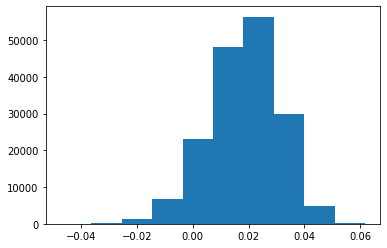

The indecision percentage around 0.02 is 0.5208317456223144
The percentage of outliers detected is 0.0773825924340929


In [6]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)
x, y = drop_outliers(x, y, outliers_indices)


### Preprocessing of data

One hot encoding the data is troubling for my setup and for google colab. The first one is unable to perform the task in reasonable time, while the second one runs out of RAM. I tried both the encoder os scikit learn and a custom encoder of mine that you can find here. The main problem is the size of the end result.

In [ ]:
def one_hot_encoder(pos,length):
  """
  One hot encode a list of unique elements

  @param pos: int64 
  @param length: int64 
  """
  encoded = np.zeros(length)
  encoded[pos] = 1
  return encoded

In [ ]:
#remove duplicate sequences in case they exist
#Kmer = [one_hot_encoder(i,len(relKa[:,0])) for i in range(len(relKa[:,0]))]
#create the encoding for all sequences
#Kmer_encode = [ for i in range(len(Kmer))]
#Kmer

In [ ]:

# initialize a one hot encoder that ignores the unseen sequences
# enc = OneHotEncoder(handle_unknown='ignore')
# use the sequences of the data for the initialization
# enc.fit(Kmer_encode)
# encode the sequences
# enc.transform(Kmer_encode).toarray()


In [ ]:
def standardization(x):
  """
  Standardization of elements for a vector x
  @param:x np.ndarray
  """
  mean = np.mean(x)
  #print(mean)
  std = np.std(x)
  #print(std)
  x = np.apply_along_axis(lambda y: (y - mean)/std, 0, x)
  return x

In [ ]:
#standardize all features
std_x=np.apply_along_axis(standardization, 1, x)

In [8]:
# randomly split the dataset in a 70/30 split
# change the train_size for partitions of different size
# rerun for different partitions
X_train, X_test, y_train, y_test = train_test_split(x, y,  train_size=0.7, random_state=33, shuffle=True)
y_train = y_train.flatten()
y_test = y_test.flatten()

## Initial Training of the regression method 

We choose Xgboost as our model for this approach.

In [7]:
#Set the parameters for the XGBRegressor
#we will use the GPU, otherwise it does not train
param_dict = {
    'subsample': 0.7,
    'learning_rate': 0.1,
    'lambda': 3.8999999999999995, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel': 0.5,
    'max_depth':15,
    'n_estimators':1000,
    'objective': 'reg:squarederror',
    'tree_method': 'hist' #'tree_method' : 'gpu_hist' 
}

In [ ]:
#Cross validation for initial data and Xgboost
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'), features, relKa, scoring='neg_mean_squared_error')

In [ ]:
print("Basic loss for XGBoost:",np.mean((-scores)**0.5))

In [10]:
#model of XBGRegressor without extensive parameter tuning
model=XGBRegressor(**param_dict)

In [11]:
#fit the model
model.fit(X_train,y_train,eval_metric="rmse")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=3.8999999999999995,
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=3.9000001, scale_pos_weight=1, subsample=0.7,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [13]:
# do some predictions with the model
y_pred = model.predict(X_test)

In [14]:
print(y_pred,y_test)

[0.22999553 0.13262266 0.16418323 ... 0.17779203 0.15697128 0.1393653 ] [0.226347159 0.122403552 0.175266704 ... 0.162094575 0.176168078
 0.132676314]


In [15]:
#mean squared error
print("Initial Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("Pearson correlation of predictions and true values:",pearsonr(y_test,y_pred)[0])
print("Spearman correlation of predictions and true values:",spearmanr(y_test,y_pred)[0])
print("P-value for uncorelated vectors hypothesis:",spearmanr(y_test,y_pred)[1])

Initial Mean Squared Error: 0.0005335227081801504
Pearson correlation of predictions and true values: 0.9666972669399115
Spearman correlation of predictions and true values: 0.9003138117554393
P-value for uncorelated vectors hypothesis: 0.0


Currently we see that the prediction and the true value for the validation sets are highly correlated.

## Logarithmic approach

In [7]:
log_relKa = [-np.log(i) for i in y.flatten()]
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(x, log_relKa,  train_size=0.7, random_state=33, shuffle=True)

In [10]:
model=XGBRegressor(**param_dict)
model.fit(X_train_log,y_train_log,eval_metric="rmse")
y_pred = model.predict(X_test_log)
print("Initial Mean Squared Error:",mean_squared_error(y_test_log,y_pred))
print("Pearson correlation of predictions and true values:",pearsonr(y_test_log,y_pred)[0])
print("Spearman correlation of predictions and true values:",spearmanr(y_test_log,y_pred)[0])
print("P-value for uncorelated vectors hypothesis:",spearmanr(y_test_log,y_pred)[1])

Initial Mean Squared Error: 0.014639760111481359
Pearson correlation of predictions and true values: 0.9452310962406928
Spearman correlation of predictions and true values: 0.9038379603326974
P-value for uncorelated vectors hypothesis: 0.0


## Error Analysis

The first step of doing an error analysis is to plot the loss over different iterations, both for the train set, as well as for the validation set.

In order to give a more complete idea of the behavior of the loss we will train the model for 5 different random splits of the dataset and plot the mean of the score of the model, as well as it's variance, over each iteration.

In [7]:
def score_metrics(X,y,params,iterations = 5):
  """
  Returns 2-2d arrays, each of the arrays has 1 row for each iteration.
  @param x: numpy.ndarray
  @param y: numpy.ndarray
  @param model:dictionary
  @param iterations: int64
  """
  training_scores=[]
  testing_scores=[]
  for i in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size=0.7, random_state=None, shuffle=True)
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    model=XGBRegressor(**param_dict)
    model.fit(X_train,y_train,eval_metric="rmse",eval_set=[(X_train,y_train),(X_test,y_test)])
    training_scores.append(model.evals_result()['validation_0']['rmse'])
    testing_scores.append(model.evals_result()['validation_1']['rmse'])
    print(len(testing_scores))
    print(len(testing_scores[i]))
  return np.array(training_scores).T, np.array(testing_scores).T

In [8]:
training_scores, testing_scores = score_metrics(x,y,param_dict,iterations=3)
# try with iterations=1 if you dont need to convince yourself that the general behavior 
# can be represented by just a random split. 
# Otherwise run with iterations = 3

[0]	validation_0-rmse:0.28859	validation_1-rmse:0.28840
[1]	validation_0-rmse:0.26094	validation_1-rmse:0.26087
[2]	validation_0-rmse:0.23613	validation_1-rmse:0.23620
[3]	validation_0-rmse:0.21380	validation_1-rmse:0.21403
[4]	validation_0-rmse:0.19380	validation_1-rmse:0.19417
[5]	validation_0-rmse:0.17579	validation_1-rmse:0.17633
[6]	validation_0-rmse:0.15961	validation_1-rmse:0.16034
[7]	validation_0-rmse:0.14502	validation_1-rmse:0.14599
[8]	validation_0-rmse:0.13201	validation_1-rmse:0.13319
[9]	validation_0-rmse:0.12041	validation_1-rmse:0.12179
[10]	validation_0-rmse:0.10996	validation_1-rmse:0.11153
[11]	validation_0-rmse:0.10057	validation_1-rmse:0.10241
[12]	validation_0-rmse:0.09216	validation_1-rmse:0.09426
[13]	validation_0-rmse:0.08448	validation_1-rmse:0.08693
[14]	validation_0-rmse:0.07783	validation_1-rmse:0.08057
[15]	validation_0-rmse:0.07170	validation_1-rmse:0.07479
[16]	validation_0-rmse:0.06628	validation_1-rmse:0.06973
[17]	validation_0-rmse:0.06139	validation

[144]	validation_0-rmse:0.00605	validation_1-rmse:0.02486
[145]	validation_0-rmse:0.00600	validation_1-rmse:0.02484
[146]	validation_0-rmse:0.00595	validation_1-rmse:0.02483
[147]	validation_0-rmse:0.00592	validation_1-rmse:0.02482
[148]	validation_0-rmse:0.00589	validation_1-rmse:0.02480
[149]	validation_0-rmse:0.00586	validation_1-rmse:0.02479
[150]	validation_0-rmse:0.00582	validation_1-rmse:0.02477
[151]	validation_0-rmse:0.00577	validation_1-rmse:0.02475
[152]	validation_0-rmse:0.00573	validation_1-rmse:0.02474
[153]	validation_0-rmse:0.00567	validation_1-rmse:0.02472
[154]	validation_0-rmse:0.00562	validation_1-rmse:0.02470
[155]	validation_0-rmse:0.00558	validation_1-rmse:0.02469
[156]	validation_0-rmse:0.00554	validation_1-rmse:0.02467
[157]	validation_0-rmse:0.00550	validation_1-rmse:0.02466
[158]	validation_0-rmse:0.00546	validation_1-rmse:0.02464
[159]	validation_0-rmse:0.00542	validation_1-rmse:0.02463
[160]	validation_0-rmse:0.00538	validation_1-rmse:0.02461
[161]	validati

[286]	validation_0-rmse:0.00259	validation_1-rmse:0.02372
[287]	validation_0-rmse:0.00258	validation_1-rmse:0.02372
[288]	validation_0-rmse:0.00256	validation_1-rmse:0.02371
[289]	validation_0-rmse:0.00255	validation_1-rmse:0.02371
[290]	validation_0-rmse:0.00254	validation_1-rmse:0.02371
[291]	validation_0-rmse:0.00253	validation_1-rmse:0.02371
[292]	validation_0-rmse:0.00252	validation_1-rmse:0.02370
[293]	validation_0-rmse:0.00251	validation_1-rmse:0.02370
[294]	validation_0-rmse:0.00249	validation_1-rmse:0.02370
[295]	validation_0-rmse:0.00248	validation_1-rmse:0.02369
[296]	validation_0-rmse:0.00247	validation_1-rmse:0.02369
[297]	validation_0-rmse:0.00246	validation_1-rmse:0.02369
[298]	validation_0-rmse:0.00245	validation_1-rmse:0.02369
[299]	validation_0-rmse:0.00244	validation_1-rmse:0.02368
[300]	validation_0-rmse:0.00243	validation_1-rmse:0.02368
[301]	validation_0-rmse:0.00241	validation_1-rmse:0.02368
[302]	validation_0-rmse:0.00240	validation_1-rmse:0.02367
[303]	validati

[428]	validation_0-rmse:0.00131	validation_1-rmse:0.02344
[429]	validation_0-rmse:0.00130	validation_1-rmse:0.02344
[430]	validation_0-rmse:0.00130	validation_1-rmse:0.02343
[431]	validation_0-rmse:0.00129	validation_1-rmse:0.02343
[432]	validation_0-rmse:0.00129	validation_1-rmse:0.02343
[433]	validation_0-rmse:0.00128	validation_1-rmse:0.02343
[434]	validation_0-rmse:0.00128	validation_1-rmse:0.02343
[435]	validation_0-rmse:0.00128	validation_1-rmse:0.02343
[436]	validation_0-rmse:0.00127	validation_1-rmse:0.02343
[437]	validation_0-rmse:0.00126	validation_1-rmse:0.02343
[438]	validation_0-rmse:0.00126	validation_1-rmse:0.02343
[439]	validation_0-rmse:0.00126	validation_1-rmse:0.02342
[440]	validation_0-rmse:0.00125	validation_1-rmse:0.02342
[441]	validation_0-rmse:0.00124	validation_1-rmse:0.02342
[442]	validation_0-rmse:0.00124	validation_1-rmse:0.02342
[443]	validation_0-rmse:0.00123	validation_1-rmse:0.02342
[444]	validation_0-rmse:0.00123	validation_1-rmse:0.02342
[445]	validati

[570]	validation_0-rmse:0.00072	validation_1-rmse:0.02333
[571]	validation_0-rmse:0.00072	validation_1-rmse:0.02333
[572]	validation_0-rmse:0.00071	validation_1-rmse:0.02333
[573]	validation_0-rmse:0.00071	validation_1-rmse:0.02333
[574]	validation_0-rmse:0.00071	validation_1-rmse:0.02333
[575]	validation_0-rmse:0.00071	validation_1-rmse:0.02333
[576]	validation_0-rmse:0.00071	validation_1-rmse:0.02333
[577]	validation_0-rmse:0.00070	validation_1-rmse:0.02333
[578]	validation_0-rmse:0.00070	validation_1-rmse:0.02333
[579]	validation_0-rmse:0.00070	validation_1-rmse:0.02333
[580]	validation_0-rmse:0.00069	validation_1-rmse:0.02333
[581]	validation_0-rmse:0.00069	validation_1-rmse:0.02333
[582]	validation_0-rmse:0.00069	validation_1-rmse:0.02333
[583]	validation_0-rmse:0.00069	validation_1-rmse:0.02333
[584]	validation_0-rmse:0.00068	validation_1-rmse:0.02333
[585]	validation_0-rmse:0.00068	validation_1-rmse:0.02332
[586]	validation_0-rmse:0.00068	validation_1-rmse:0.02332
[587]	validati

[712]	validation_0-rmse:0.00052	validation_1-rmse:0.02330
[713]	validation_0-rmse:0.00052	validation_1-rmse:0.02330
[714]	validation_0-rmse:0.00052	validation_1-rmse:0.02330
[715]	validation_0-rmse:0.00052	validation_1-rmse:0.02330
[716]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[717]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[718]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[719]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[720]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[721]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[722]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[723]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[724]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[725]	validation_0-rmse:0.00051	validation_1-rmse:0.02330
[726]	validation_0-rmse:0.00051	validation_1-rmse:0.02329
[727]	validation_0-rmse:0.00051	validation_1-rmse:0.02329
[728]	validation_0-rmse:0.00051	validation_1-rmse:0.02329
[729]	validati

[854]	validation_0-rmse:0.00049	validation_1-rmse:0.02329
[855]	validation_0-rmse:0.00049	validation_1-rmse:0.02329
[856]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[857]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[858]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[859]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[860]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[861]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[862]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[863]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[864]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[865]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[866]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[867]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[868]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[869]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[870]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[871]	validati

[996]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[997]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[998]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
[999]	validation_0-rmse:0.00048	validation_1-rmse:0.02329
1
1000
[0]	validation_0-rmse:0.28838	validation_1-rmse:0.28887
[1]	validation_0-rmse:0.26085	validation_1-rmse:0.26138
[2]	validation_0-rmse:0.23607	validation_1-rmse:0.23665
[3]	validation_0-rmse:0.21381	validation_1-rmse:0.21448
[4]	validation_0-rmse:0.19377	validation_1-rmse:0.19450
[5]	validation_0-rmse:0.17577	validation_1-rmse:0.17660
[6]	validation_0-rmse:0.15969	validation_1-rmse:0.16064
[7]	validation_0-rmse:0.14529	validation_1-rmse:0.14634
[8]	validation_0-rmse:0.13225	validation_1-rmse:0.13347
[9]	validation_0-rmse:0.12057	validation_1-rmse:0.12199
[10]	validation_0-rmse:0.11012	validation_1-rmse:0.11172
[11]	validation_0-rmse:0.10070	validation_1-rmse:0.10258
[12]	validation_0-rmse:0.09225	validation_1-rmse:0.09441
[13]	validation_0-rmse:0.08473

[140]	validation_0-rmse:0.00609	validation_1-rmse:0.02482
[141]	validation_0-rmse:0.00605	validation_1-rmse:0.02480
[142]	validation_0-rmse:0.00602	validation_1-rmse:0.02479
[143]	validation_0-rmse:0.00597	validation_1-rmse:0.02477
[144]	validation_0-rmse:0.00593	validation_1-rmse:0.02475
[145]	validation_0-rmse:0.00589	validation_1-rmse:0.02474
[146]	validation_0-rmse:0.00586	validation_1-rmse:0.02472
[147]	validation_0-rmse:0.00581	validation_1-rmse:0.02471
[148]	validation_0-rmse:0.00576	validation_1-rmse:0.02468
[149]	validation_0-rmse:0.00572	validation_1-rmse:0.02467
[150]	validation_0-rmse:0.00566	validation_1-rmse:0.02465
[151]	validation_0-rmse:0.00563	validation_1-rmse:0.02464
[152]	validation_0-rmse:0.00558	validation_1-rmse:0.02462
[153]	validation_0-rmse:0.00553	validation_1-rmse:0.02460
[154]	validation_0-rmse:0.00550	validation_1-rmse:0.02459
[155]	validation_0-rmse:0.00547	validation_1-rmse:0.02458
[156]	validation_0-rmse:0.00544	validation_1-rmse:0.02457
[157]	validati

[282]	validation_0-rmse:0.00250	validation_1-rmse:0.02361
[283]	validation_0-rmse:0.00249	validation_1-rmse:0.02361
[284]	validation_0-rmse:0.00247	validation_1-rmse:0.02360
[285]	validation_0-rmse:0.00246	validation_1-rmse:0.02360
[286]	validation_0-rmse:0.00244	validation_1-rmse:0.02360
[287]	validation_0-rmse:0.00243	validation_1-rmse:0.02360
[288]	validation_0-rmse:0.00243	validation_1-rmse:0.02359
[289]	validation_0-rmse:0.00241	validation_1-rmse:0.02359
[290]	validation_0-rmse:0.00240	validation_1-rmse:0.02358
[291]	validation_0-rmse:0.00238	validation_1-rmse:0.02358
[292]	validation_0-rmse:0.00237	validation_1-rmse:0.02358
[293]	validation_0-rmse:0.00235	validation_1-rmse:0.02357
[294]	validation_0-rmse:0.00234	validation_1-rmse:0.02357
[295]	validation_0-rmse:0.00232	validation_1-rmse:0.02357
[296]	validation_0-rmse:0.00231	validation_1-rmse:0.02356
[297]	validation_0-rmse:0.00230	validation_1-rmse:0.02356
[298]	validation_0-rmse:0.00229	validation_1-rmse:0.02356
[299]	validati

[424]	validation_0-rmse:0.00129	validation_1-rmse:0.02332
[425]	validation_0-rmse:0.00128	validation_1-rmse:0.02332
[426]	validation_0-rmse:0.00128	validation_1-rmse:0.02332
[427]	validation_0-rmse:0.00128	validation_1-rmse:0.02332
[428]	validation_0-rmse:0.00127	validation_1-rmse:0.02332
[429]	validation_0-rmse:0.00126	validation_1-rmse:0.02332
[430]	validation_0-rmse:0.00126	validation_1-rmse:0.02332
[431]	validation_0-rmse:0.00126	validation_1-rmse:0.02332
[432]	validation_0-rmse:0.00125	validation_1-rmse:0.02332
[433]	validation_0-rmse:0.00124	validation_1-rmse:0.02331
[434]	validation_0-rmse:0.00124	validation_1-rmse:0.02331
[435]	validation_0-rmse:0.00123	validation_1-rmse:0.02331
[436]	validation_0-rmse:0.00122	validation_1-rmse:0.02331
[437]	validation_0-rmse:0.00122	validation_1-rmse:0.02331
[438]	validation_0-rmse:0.00121	validation_1-rmse:0.02331
[439]	validation_0-rmse:0.00121	validation_1-rmse:0.02331
[440]	validation_0-rmse:0.00120	validation_1-rmse:0.02331
[441]	validati

[566]	validation_0-rmse:0.00072	validation_1-rmse:0.02322
[567]	validation_0-rmse:0.00072	validation_1-rmse:0.02322
[568]	validation_0-rmse:0.00072	validation_1-rmse:0.02322
[569]	validation_0-rmse:0.00072	validation_1-rmse:0.02322
[570]	validation_0-rmse:0.00072	validation_1-rmse:0.02322
[571]	validation_0-rmse:0.00071	validation_1-rmse:0.02322
[572]	validation_0-rmse:0.00071	validation_1-rmse:0.02322
[573]	validation_0-rmse:0.00071	validation_1-rmse:0.02322
[574]	validation_0-rmse:0.00071	validation_1-rmse:0.02322
[575]	validation_0-rmse:0.00070	validation_1-rmse:0.02321
[576]	validation_0-rmse:0.00070	validation_1-rmse:0.02321
[577]	validation_0-rmse:0.00070	validation_1-rmse:0.02321
[578]	validation_0-rmse:0.00070	validation_1-rmse:0.02321
[579]	validation_0-rmse:0.00070	validation_1-rmse:0.02321
[580]	validation_0-rmse:0.00069	validation_1-rmse:0.02321
[581]	validation_0-rmse:0.00069	validation_1-rmse:0.02321
[582]	validation_0-rmse:0.00069	validation_1-rmse:0.02321
[583]	validati

[708]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[709]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[710]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[711]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[712]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[713]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[714]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[715]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[716]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[717]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[718]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[719]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[720]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[721]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[722]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[723]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[724]	validation_0-rmse:0.00051	validation_1-rmse:0.02318
[725]	validati

[850]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[851]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[852]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[853]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[854]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[855]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[856]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[857]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[858]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[859]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[860]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[861]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[862]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[863]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[864]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[865]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[866]	validation_0-rmse:0.00049	validation_1-rmse:0.02318
[867]	validati

[992]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[993]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[994]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[995]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[996]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[997]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[998]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
[999]	validation_0-rmse:0.00048	validation_1-rmse:0.02318
2
1000
[0]	validation_0-rmse:0.28845	validation_1-rmse:0.28879
[1]	validation_0-rmse:0.26091	validation_1-rmse:0.26131
[2]	validation_0-rmse:0.23608	validation_1-rmse:0.23657
[3]	validation_0-rmse:0.21382	validation_1-rmse:0.21441
[4]	validation_0-rmse:0.19378	validation_1-rmse:0.19449
[5]	validation_0-rmse:0.17586	validation_1-rmse:0.17669
[6]	validation_0-rmse:0.15968	validation_1-rmse:0.16067
[7]	validation_0-rmse:0.14522	validation_1-rmse:0.14637
[8]	validation_0-rmse:0.13216	validation_1-rmse:0.13348
[9]	validation_0-rmse:0.1

[136]	validation_0-rmse:0.00658	validation_1-rmse:0.02465
[137]	validation_0-rmse:0.00652	validation_1-rmse:0.02462
[138]	validation_0-rmse:0.00648	validation_1-rmse:0.02461
[139]	validation_0-rmse:0.00642	validation_1-rmse:0.02458
[140]	validation_0-rmse:0.00638	validation_1-rmse:0.02457
[141]	validation_0-rmse:0.00634	validation_1-rmse:0.02455
[142]	validation_0-rmse:0.00628	validation_1-rmse:0.02453
[143]	validation_0-rmse:0.00624	validation_1-rmse:0.02452
[144]	validation_0-rmse:0.00619	validation_1-rmse:0.02449
[145]	validation_0-rmse:0.00615	validation_1-rmse:0.02448
[146]	validation_0-rmse:0.00609	validation_1-rmse:0.02446
[147]	validation_0-rmse:0.00605	validation_1-rmse:0.02444
[148]	validation_0-rmse:0.00600	validation_1-rmse:0.02442
[149]	validation_0-rmse:0.00594	validation_1-rmse:0.02440
[150]	validation_0-rmse:0.00589	validation_1-rmse:0.02439
[151]	validation_0-rmse:0.00586	validation_1-rmse:0.02437
[152]	validation_0-rmse:0.00581	validation_1-rmse:0.02436
[153]	validati

[278]	validation_0-rmse:0.00266	validation_1-rmse:0.02334
[279]	validation_0-rmse:0.00265	validation_1-rmse:0.02334
[280]	validation_0-rmse:0.00263	validation_1-rmse:0.02333
[281]	validation_0-rmse:0.00262	validation_1-rmse:0.02333
[282]	validation_0-rmse:0.00261	validation_1-rmse:0.02332
[283]	validation_0-rmse:0.00259	validation_1-rmse:0.02332
[284]	validation_0-rmse:0.00258	validation_1-rmse:0.02332
[285]	validation_0-rmse:0.00257	validation_1-rmse:0.02331
[286]	validation_0-rmse:0.00254	validation_1-rmse:0.02331
[287]	validation_0-rmse:0.00253	validation_1-rmse:0.02330
[288]	validation_0-rmse:0.00252	validation_1-rmse:0.02330
[289]	validation_0-rmse:0.00251	validation_1-rmse:0.02330
[290]	validation_0-rmse:0.00249	validation_1-rmse:0.02330
[291]	validation_0-rmse:0.00248	validation_1-rmse:0.02329
[292]	validation_0-rmse:0.00247	validation_1-rmse:0.02329
[293]	validation_0-rmse:0.00246	validation_1-rmse:0.02329
[294]	validation_0-rmse:0.00244	validation_1-rmse:0.02328
[295]	validati

[420]	validation_0-rmse:0.00132	validation_1-rmse:0.02303
[421]	validation_0-rmse:0.00132	validation_1-rmse:0.02303
[422]	validation_0-rmse:0.00131	validation_1-rmse:0.02303
[423]	validation_0-rmse:0.00130	validation_1-rmse:0.02303
[424]	validation_0-rmse:0.00130	validation_1-rmse:0.02303
[425]	validation_0-rmse:0.00129	validation_1-rmse:0.02303
[426]	validation_0-rmse:0.00129	validation_1-rmse:0.02303
[427]	validation_0-rmse:0.00128	validation_1-rmse:0.02303
[428]	validation_0-rmse:0.00128	validation_1-rmse:0.02303
[429]	validation_0-rmse:0.00128	validation_1-rmse:0.02303
[430]	validation_0-rmse:0.00127	validation_1-rmse:0.02302
[431]	validation_0-rmse:0.00126	validation_1-rmse:0.02302
[432]	validation_0-rmse:0.00126	validation_1-rmse:0.02302
[433]	validation_0-rmse:0.00125	validation_1-rmse:0.02302
[434]	validation_0-rmse:0.00125	validation_1-rmse:0.02302
[435]	validation_0-rmse:0.00124	validation_1-rmse:0.02302
[436]	validation_0-rmse:0.00124	validation_1-rmse:0.02302
[437]	validati

[562]	validation_0-rmse:0.00074	validation_1-rmse:0.02294
[563]	validation_0-rmse:0.00074	validation_1-rmse:0.02294
[564]	validation_0-rmse:0.00073	validation_1-rmse:0.02294
[565]	validation_0-rmse:0.00073	validation_1-rmse:0.02293
[566]	validation_0-rmse:0.00073	validation_1-rmse:0.02293
[567]	validation_0-rmse:0.00073	validation_1-rmse:0.02293
[568]	validation_0-rmse:0.00072	validation_1-rmse:0.02293
[569]	validation_0-rmse:0.00072	validation_1-rmse:0.02293
[570]	validation_0-rmse:0.00072	validation_1-rmse:0.02293
[571]	validation_0-rmse:0.00072	validation_1-rmse:0.02293
[572]	validation_0-rmse:0.00072	validation_1-rmse:0.02293
[573]	validation_0-rmse:0.00071	validation_1-rmse:0.02293
[574]	validation_0-rmse:0.00071	validation_1-rmse:0.02293
[575]	validation_0-rmse:0.00071	validation_1-rmse:0.02293
[576]	validation_0-rmse:0.00071	validation_1-rmse:0.02293
[577]	validation_0-rmse:0.00070	validation_1-rmse:0.02293
[578]	validation_0-rmse:0.00070	validation_1-rmse:0.02293
[579]	validati

[704]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[705]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[706]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[707]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[708]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[709]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[710]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[711]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[712]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[713]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[714]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[715]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[716]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[717]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[718]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[719]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[720]	validation_0-rmse:0.00051	validation_1-rmse:0.02290
[721]	validati

[846]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[847]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[848]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[849]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[850]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[851]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[852]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[853]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[854]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[855]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[856]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[857]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[858]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[859]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[860]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[861]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[862]	validation_0-rmse:0.00049	validation_1-rmse:0.02289
[863]	validati

[988]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[989]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[990]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[991]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[992]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[993]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[994]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[995]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[996]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[997]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[998]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
[999]	validation_0-rmse:0.00048	validation_1-rmse:0.02289
3
1000


In [9]:
print(training_scores)

[[0.288589 0.288376 0.288452]
 [0.260937 0.260851 0.260911]
 [0.236134 0.236067 0.236077]
 ...
 [0.000477 0.00048  0.000478]
 [0.000477 0.00048  0.000478]
 [0.000477 0.00048  0.000478]]


Text(0.5, 1.0, 'Loss over iterations')

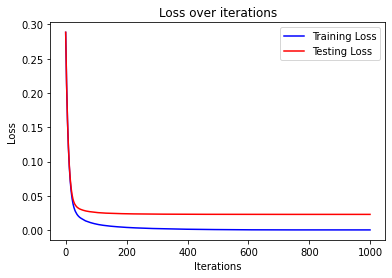

In [11]:
# Plot
plt.plot(training_scores.mean(axis=1), color = 'Blue', label="Training Loss")
plt.plot(testing_scores.mean(axis=1), color = 'Red', label="Testing Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over iterations')

As we can see in the plot above we don't have overfitting in our model. Also by the print of the training scores we can see that in multiple training sessions with different random splits we have the same scores, which means that in average the model is not overfitting. 

# Data Augmentation

In [30]:
def square_augmentation(X):
    X_1 = X
    X_2 = np.square(X)
    return np.concatenate((X_1,X_2),axis=1)

In [31]:
x_square = square_augmentation(x)
X_train, X_test, y_train, y_test = train_test_split(x_square, y,  train_size=0.7, random_state=None, shuffle=True)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
model=XGBRegressor(**param_dict)
model.fit(X_train, y_train,eval_metric="rmse")
y_pred = model.predict(X_test)
print("Initial Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("Pearson correlation of predictions and true values:",pearsonr(y_test,y_pred)[0])
print("Spearman correlation of predictions and true values:",spearmanr(y_test,y_pred)[0])
print("P-value for uncorelated vectors hypothesis:",spearmanr(y_test,y_pred)[1])

In [52]:
def periodic_augmentation(X):
    X_1 = X
    #print(np.exp(X[0][5]))
    X_2 = np.array([np.sin(i) for y in x for i in y]).reshape((157381, 318))
    return np.concatenate((X_1,X_2),axis=1)

In [54]:
print(periodic_augmentation(x).shape)

(157381, 636)


In [55]:
x_square = periodic_augmentation(x)
X_train, X_test, y_train, y_test = train_test_split(x_square, y,  train_size=0.7, random_state=None, shuffle=True)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
model=XGBRegressor(**param_dict)
model.fit(X_train, y_train,eval_metric="rmse")
y_pred = model.predict(X_test)
print("Initial Mean Squared Error:",mean_squared_error(y_test,y_pred))
print("Pearson correlation of predictions and true values:",pearsonr(y_test,y_pred)[0])
print("Spearman correlation of predictions and true values:",spearmanr(y_test,y_pred)[0])
print("P-value for uncorelated vectors hypothesis:",spearmanr(y_test,y_pred)[1])